In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import csv

from VAE import (
    train_conditional_vae, 
    train_conditional_subspace_vae, 
    train_discover_vae, 
    train_base_model,
    FingerprintDataset,
    BaseVAETrainer,
    ConditionalVAETrainer,
    ConditionalSubspaceVAETrainer,
    DiscoverVAETrainer,
    )
from fg_funcs import (
    extract_and_save_latents,
    extract_prefixed_arrays,
    evaluate_reconstructions,
    visualize_latent_space_per_fg,
    metric,
    get_nearest_neighbors,
    visualize_latent_space_tanimoto,
)

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

/Users/damianelkins/miniconda3/envs/rdkit-thesis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
TRAIN = []
GET_LATENTS = False
GET_EVAL = False
VIS_CUR = False
VIS_FULL = False

In [ ]:
latent_dims = [4, 8, 16]  # You can change this to test different latent dimensions
encoder_hidden_dims = [1024, 512, 256, 128]
decoder_hidden_dims = [128, 512]  
decoder_z_hidden_dims = [128, 512]  # Decoder layers for DISCoVeR
latent_dims_z = [4, 8, 16] # for CSVAE and DISCoVeR
latent_dims_w = [2, 4, 8] # for CSVAE and DISCoVeR
encoder_hidden_dims_z = [1024, 512, 256, 128] # for CSVAE and DISCoVeR
encoder_hidden_dims_w = [1024, 512, 256, 128] # for CSVAE and DISCoVeR
adversarial_hidden_dims = [8] 
batch_size = 64
learning_rate = 1e-3
max_epochs = 5


In [ ]:
for latent_dim, latent_dim_z, latent_dim_w in zip(latent_dims, latent_dims_z, latent_dims_w):
    for MODEL in TRAIN:
        model_type, dataset_type = MODEL.split('_')

        if dataset_type == 'CUR':
            # Load the curated dataset
            curated_dataset = pd.read_pickle('data/chembl_35_fg_scaf_curated.pkl')

            # Convert the fingerprint to numpy arrays
            curated_dataset['fingerprint_array'] = curated_dataset['fingerprint_array'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros((2048,), dtype=int))
            curated_dataset['fg_array'] = curated_dataset['fg_array'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros((100,), dtype=int))

            MODEL_OUTPUT = 'models/small_models'  # Directory to save trained models
            dataset = curated_dataset  # Use the curated dataset for training
            sparse = False

            input_dim = 2048
            fg_dim = 4

        elif dataset_type == 'FULL':
            # Load the full dataset
            full_dataset = pd.read_csv("data/chembl_35_fg_full.csv")

            MODEL_OUTPUT = 'models/large_models'  # Directory to save trained models
            dataset = full_dataset  # Use the full dataset for training
            sparse = True

            input_dim = 2048
            fg_dim = 50

        torch.manual_seed(42)

        if model_type is None:
            raise ValueError("MODEL must be defined before training.")
        elif model_type == 'Base':

            print("Training BaseVAE model...")
            

            vae_trainer = train_base_model(
                dataset=dataset,
                input_dim=input_dim,
                latent_dim=latent_dim,
                fg_dim=fg_dim,  # BaseVAE does not use fg_array for logging purposes only
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                batch_size=batch_size,
                learning_rate=learning_rate,
                max_epochs=max_epochs,
                sparse=sparse
            )

        elif model_type == 'CVAE':

            print("Training CVAE model...")

            vae_trainer = train_conditional_vae(
                dataset=dataset,
                fingerprint_dim=input_dim,
                fg_dim=fg_dim,
                latent_dim=latent_dim,
                encoder_hidden_dims=encoder_hidden_dims,
                decoder_hidden_dims=decoder_hidden_dims,
                batch_size=batch_size,
                learning_rate=learning_rate,
                max_epochs=max_epochs,
                sparse=sparse
            )

        elif model_type == 'CSVAE':

            print("Training CSVAE model based on the NeurIPS 2018 paper...")


            vae_trainer = train_conditional_subspace_vae(
                dataset=dataset,
                fingerprint_dim=input_dim,
                fg_dim=fg_dim,
                latent_dim_z=latent_dim_z,
                latent_dim_w=latent_dim_w,
                encoder_hidden_dims_z=encoder_hidden_dims_z,
                encoder_hidden_dims_w=encoder_hidden_dims_w,
                decoder_hidden_dims=decoder_hidden_dims,
                adversarial_hidden_dims=adversarial_hidden_dims,
                batch_size=batch_size,
                learning_rate=learning_rate,
                max_epochs=max_epochs,
                sparse=sparse
            )

        elif model_type == 'DISCoVeR':

            print("Training DISCoVeR VAE model...")

            vae_trainer = train_discover_vae(
                dataset=dataset,
                fingerprint_dim=input_dim,
                fg_dim=fg_dim,
                latent_dim_z=latent_dim_z,
                latent_dim_w=latent_dim_w,
                encoder_hidden_dims_z=encoder_hidden_dims_z,
                encoder_hidden_dims_w=encoder_hidden_dims_w,
                decoder_hidden_dims=decoder_hidden_dims,
                decoder_z_hidden_dims=decoder_z_hidden_dims,
                adversarial_hidden_dims=adversarial_hidden_dims,
                batch_size=batch_size,
                learning_rate=learning_rate,
                max_epochs=max_epochs,
                sparse=sparse
            )

        # Free memory after each model
        del vae_trainer


In [ ]:
# Create list of models and locations
latent_dim = latent_dims[1]
small_models = [
    ("Base", f"checkpoints/fg_bvae_4_{latent_dim}/best-checkpoint.ckpt", BaseVAETrainer),
    ("CVAE", f"checkpoints/fg_cvae_4_{latent_dim}/best-checkpoint.ckpt", ConditionalVAETrainer),
    ("CSVAE", f"checkpoints/fg_csvae_4_{latent_dim}/best-checkpoint.ckpt", ConditionalSubspaceVAETrainer),
    ("DISCoVeR", f"checkpoints/fg_dvae_4_{latent_dim}/best-checkpoint.ckpt", DiscoverVAETrainer),
]

large_models = [
    ("Base", f"checkpoints/fg_bvae_50_{latent_dim}/best-checkpoint.ckpt", BaseVAETrainer),
    ("CVAE", f"checkpoints/fg_cvae_50_{latent_dim}/best-checkpoint.ckpt", ConditionalVAETrainer),
    ("CSVAE", f"checkpoints/fg_csvae_50_{latent_dim}/best-checkpoint.ckpt", ConditionalSubspaceVAETrainer),
    ("DISCoVeR", f"checkpoints/fg_dvae_50_{latent_dim}/best-checkpoint.ckpt", DiscoverVAETrainer),
]

In [ ]:
if GET_LATENTS:
    # Create a test DataLoader
    curated_dataset = pd.read_pickle('data/chembl_35_fg_scaf_curated.pkl')

    # Convert the fingerprint to numpy arrays
    curated_dataset['fingerprint_array'] = curated_dataset['fingerprint_array'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros((2048,), dtype=int))
    curated_dataset['fg_array'] = curated_dataset['fg_array'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros((100,), dtype=int))

    # Split the dataset into train and test sets
    train_data, test_data = train_test_split(curated_dataset, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.2, random_state=42)

    test_dataset = FingerprintDataset(test_data, sparse=False)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

    for latent_dim in latent_dims:
        small_models = [
            ("Base", f"checkpoints/fg_bvae_4_{latent_dim}/best-checkpoint.ckpt", BaseVAETrainer),
            ("CVAE", f"checkpoints/fg_cvae_4_{latent_dim}/best-checkpoint.ckpt", ConditionalVAETrainer),
            ("CSVAE", f"checkpoints/fg_csvae_4_{latent_dim}/best-checkpoint.ckpt", ConditionalSubspaceVAETrainer),
            ("DISCoVeR", f"checkpoints/fg_dvae_4_{latent_dim}/best-checkpoint.ckpt", DiscoverVAETrainer),
        ]

        # Extract and save latents for small models
        for model_name, model_path, model_class in small_models:
            extract_and_save_latents(
                model_path=model_path,
                dataloader=test_dataloader,
                model_type=model_name,
                model_class=model_class,
                device=device
            )

In [ ]:
if GET_EVAL:
    # Create a test DataLoader
    curated_dataset = pd.read_pickle('data/chembl_35_fg_scaf_curated.pkl')

    # Convert the fingerprint to numpy arrays
    curated_dataset['fingerprint_array'] = curated_dataset['fingerprint_array'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros((2048,), dtype=int))
    curated_dataset['fg_array'] = curated_dataset['fg_array'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros((100,), dtype=int))

    # Split the dataset into train and test sets
    train_data, test_data = train_test_split(curated_dataset, test_size=0.2, random_state=42)
    val_data, test_data = train_test_split(test_data, test_size=0.2, random_state=42)

    test_dataset = FingerprintDataset(test_data, sparse=False)
    test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

    # Create list of models and locations
    for latent_dim in latent_dims:
        small_models = [
            ("Base", f"checkpoints/fg_bvae_4_{latent_dim}/best-checkpoint.ckpt", BaseVAETrainer),
            ("CVAE", f"checkpoints/fg_cvae_4_{latent_dim}/best-checkpoint.ckpt", ConditionalVAETrainer),
            ("CSVAE", f"checkpoints/fg_csvae_4_{latent_dim}/best-checkpoint.ckpt", ConditionalSubspaceVAETrainer),
            ("DISCoVeR", f"checkpoints/fg_dvae_4_{latent_dim}/best-checkpoint.ckpt", DiscoverVAETrainer)
        ]

        # Extract and save latents for small models
        for model_name, model_path, model_class in small_models:
            evaluate_reconstructions(
                model_path=model_path,
                dataloader=test_dataloader,
                model_type=model_name,
                model_class=model_class,
                device=device,
                thresholds=np.arange(0.4, 0.7, 0.02)
            )

In [ ]:
if GET_LATENTS:    
    try:
        # Re-run the extraction and saving process for the full dataset
        full_dataset = pd.read_csv("data/chembl_35_fg_full.csv")

        train_full, test_full = train_test_split(full_dataset, test_size=0.2, random_state=42)
        val_full, test_full = train_test_split(test_full, test_size=0.2, random_state=42)

        test_full_dataset = FingerprintDataset(test_full, sparse=True)
        full_dataloader = DataLoader(test_full_dataset, batch_size=64, shuffle=False)

        for latent_dim in latent_dims:
            large_models = [
                ("Base", f"checkpoints/fg_bvae_50_{latent_dim}/best-checkpoint.ckpt", BaseVAETrainer),
                ("CVAE", f"checkpoints/fg_cvae_50_{latent_dim}/best-checkpoint.ckpt", ConditionalVAETrainer),
                ("CSVAE", f"checkpoints/fg_csvae_50_{latent_dim}/best-checkpoint.ckpt", ConditionalSubspaceVAETrainer),
                ("DISCoVeR", f"checkpoints/fg_dvae_50_{latent_dim}/best-checkpoint.ckpt", DiscoverVAETrainer)
            ]

            for model_name, model_path, model_class in large_models:
                extract_and_save_latents(
                    model_path=model_path,
                    dataloader=full_dataloader,
                    model_type=model_name,
                    model_class=model_class,
                    device="mps"
                )
    except Exception as e:
        print(f"Error occurred while extracting latents: {e}")

In [ ]:
if GET_EVAL:
    full_dataset = pd.read_csv("data/chembl_35_fg_full.csv")

    train_full, test_full = train_test_split(full_dataset, test_size=0.2, random_state=42)
    val_full, test_full = train_test_split(test_full, test_size=0.2, random_state=42)

    test_full_dataset = FingerprintDataset(test_full, sparse=True)
    full_dataloader = DataLoader(test_full_dataset, batch_size=64, shuffle=False)

    for latent_dim in latent_dims:
        large_models = [
            ("Base", f"checkpoints/fg_bvae_50_{latent_dim}/best-checkpoint.ckpt", BaseVAETrainer),
            ("CVAE", f"checkpoints/fg_cvae_50_{latent_dim}/best-checkpoint.ckpt", ConditionalVAETrainer),
            ("CSVAE", f"checkpoints/fg_csvae_50_{latent_dim}/best-checkpoint.ckpt", ConditionalSubspaceVAETrainer),
            ("DISCoVeR", f"checkpoints/fg_dvae_50_{latent_dim}/best-checkpoint.ckpt", DiscoverVAETrainer)
        ]

        for model_name, model_path, model_class in large_models:
            evaluate_reconstructions(
                model_path=model_path,
                dataloader=full_dataloader,
                model_type=model_name,
                model_class=model_class,
                device="mps",
                thresholds=np.arange(0.5, 0.7, 0.02)
            )

In [ ]:
latents = {}
models = ['Base', 'CVAE', 'CSVAE', 'DISCoVeR']
sizes = ['4000', '80000', '91321', '1826415']
dims = ['4', '8', '16']
neighbors = 50

for model in models:
    if model in ['Base', 'CVAE']:
        terms = ['z', 'y']
    elif model in ['CSVAE', 'DISCoVeR']:
        terms = ['z', 'w', 'y']
    for size in sizes:
        for dim in dims:
            name = f"latents_{model}_{size}_{dim}"
            latent = f"latents/{name}.csv"
            latents[name] = extract_prefixed_arrays(latent, terms)
            if 'w' in terms:
                # Concatenate w and z
                latents[name]['wz'] = latents[name].apply(
                    lambda row: np.concatenate([row['w'], row['z']]), axis=1
                )

In [ ]:
method = 'umap'
cur_size = 80000
full_size = 1826415
latent_dim = 16

if VIS_CUR:
    try:
        # Visualize the latent space
        visualize_latent_space_per_fg(latents[f'latents_Base_{cur_size}_4']['z'], latents[f'latents_Base_{cur_size}_4']['y'], method, sample_size=5000, combined_title=f'Base VAE {method.upper()} {latent_dim} {'Test Set' if cur_size < 50000 else 'Train Set'}', per_fg_title=f'Base VAE by FG {method.upper()} {latent_dim} {'Test Set' if cur_size < 50000 else 'Train Set'}', save_path=f'images/base_vae_cur_{latent_dim}_{cur_size}/')
        visualize_latent_space_per_fg(latents[f'latents_CVAE_{cur_size}_4']['z'], latents[f'latents_CVAE_{cur_size}_4']['y'], method, sample_size=5000, combined_title=f'CVAE {method.upper()} {latent_dim} {'Test Set' if cur_size < 50000 else 'Train Set'}', per_fg_title=f'CVAE by FG {method.upper()} {latent_dim} {'Test Set' if cur_size < 50000 else 'Train Set'}', save_path=f'images/cvae_cur_{latent_dim}_{cur_size}/')
        visualize_latent_space_per_fg(latents[f'latents_CSVAE_{cur_size}_4']['z'], latents[f'latents_CSVAE_{cur_size}_4']['y'], method, sample_size=5000, combined_title=f'CSVAE {method.upper()} {latent_dim} {'Test Set' if cur_size < 50000 else 'Train Set'}', per_fg_title=f'CSVAE by FG {method.upper()} {latent_dim} {'Test Set' if cur_size < 50000 else 'Train Set'}', save_path=f'images/csvae_cur_{latent_dim}_{cur_size}/')
        visualize_latent_space_per_fg(latents[f'latents_DISCoVeR_{cur_size}_4']['z'], latents[f'latents_DISCoVeR_{cur_size}_4']['y'], method, sample_size=5000, combined_title=f'Discover {method.upper()} {latent_dim} {'Test Set' if cur_size < 50000 else 'Train Set'}', per_fg_title=f'Discover by FG {method.upper()} {latent_dim} {'Test Set' if cur_size < 50000 else 'Train Set'}', save_path=f'images/discover_cur_{latent_dim}_{cur_size}/')
        visualize_latent_space_per_fg(latents[f'latents_CSVAE_{cur_size}_4']['w'], latents[f'latents_CSVAE_{cur_size}_4']['y'], method, sample_size=5000, combined_title=f'CSVAE {method.upper()} {int(latent_dim/2)} {'Test Set' if cur_size < 50000 else 'Train Set'}', per_fg_title=f'CSVAE by FG {method.upper()} {int(latent_dim/2)} {'Test Set' if cur_size < 50000 else 'Train Set'}', save_path=f'images/csvae_cur_w_{latent_dim}_{cur_size}/')
        visualize_latent_space_per_fg(latents[f'latents_DISCoVeR_{cur_size}_4']['w'], latents[f'latents_DISCoVeR_{cur_size}_4']['y'], method, sample_size=5000, combined_title=f'Discover {method.upper()} {int(latent_dim/2)} {'Test Set' if cur_size < 50000 else 'Train Set'}', per_fg_title=f'Discover by FG {method.upper()} {int(latent_dim/2)} {'Test Set' if cur_size < 50000 else 'Train Set'}', save_path=f'images/discover_cur_w_{latent_dim}_{cur_size}/')
        visualize_latent_space_per_fg(latents[f'latents_CSVAE_{cur_size}_4']['wz'], latents[f'latents_CSVAE_{cur_size}_4']['y'], method, sample_size=5000, combined_title=f'CSVAE {method.upper()} {latent_dim+int(latent_dim/2)} {'Test Set' if cur_size < 50000 else 'Train Set'}', per_fg_title=f'CSVAE WZ by FG {method.upper()} {latent_dim+int(latent_dim/2)} {'Test Set' if cur_size < 50000 else 'Train Set'}', save_path=f'images/csvae_cur_wz_{latent_dim}_{cur_size}/')
        visualize_latent_space_per_fg(latents[f'latents_DISCoVeR_{cur_size}_4']['wz'], latents[f'latents_DISCoVeR_{cur_size}_4']['y'], method, sample_size=5000, combined_title=f'Discover {method.upper()} {latent_dim+int(latent_dim/2)} {'Test Set' if cur_size < 50000 else 'Train Set'}', per_fg_title=f'Discover WZ by FG {method.upper()} {latent_dim+int(latent_dim/2)} {'Test Set' if cur_size < 50000 else 'Train Set'}', save_path=f'images/discover_cur_wz_{latent_dim}_{cur_size}/')
    except Exception as e:
        print(f"Error occurred while visualizing current latents: {e}")

if VIS_FULL:
    try:
        visualize_latent_space_per_fg(latents[f'latents_Base_{full_size}_50']['z'], latents[f'latents_Base_{full_size}_50']['y'], method, sample_size=5000, combined_title=f'Base VAE {method.upper()} {latent_dim}', per_fg_title=f'Base VAE by FG {method.upper()} {latent_dim}', save_path=f'images/base_vae_full_{latent_dim}_{full_size}/')
        visualize_latent_space_per_fg(latents[f'latents_CVAE_{full_size}_50']['z'], latents[f'latents_CVAE_{full_size}_50']['y'], method, sample_size=5000, combined_title=f'CVAE {method.upper()} {latent_dim}', per_fg_title=f'CVAE by FG {method.upper()} {latent_dim}', save_path=f'images/cvae_full_{latent_dim}_{full_size}/')
        visualize_latent_space_per_fg(latents[f'latents_CSVAE_{full_size}_50']['z'], latents[f'latents_CSVAE_{full_size}_50']['y'], method, sample_size=5000, combined_title=f'CSVAE {method.upper()} {latent_dim}', per_fg_title=f'CSVAE by FG {method.upper()} {latent_dim}', save_path=f'images/csvae_full_{latent_dim}_{full_size}/')
        visualize_latent_space_per_fg(latents[f'latents_DISCoVeR_{full_size}_50']['z'], latents[f'latents_DISCoVeR_{full_size}_50']['y'], method, sample_size=5000, combined_title=f'Discover {method.upper()} {latent_dim}', per_fg_title=f'Discover by FG {method.upper()} {latent_dim}', save_path=f'images/discover_full_{latent_dim}_{full_size}/')
        visualize_latent_space_per_fg(latents[f'latents_CSVAE_{full_size}_50']['w'], latents[f'latents_CSVAE_{full_size}_50']['y'], method, sample_size=5000, combined_title=f'CSVAE {method.upper()} {latent_dim}', per_fg_title=f'CSVAE by FG {method.upper()} {latent_dim}', save_path=f'images/csvae_full_w_{latent_dim}_{full_size}/')
        visualize_latent_space_per_fg(latents[f'latents_DISCoVeR_{full_size}_50']['w'], latents[f'latents_DISCoVeR_{full_size}_50']['y'], method, sample_size=5000, combined_title=f'Discover {method.upper()} {latent_dim}', per_fg_title=f'Discover by FG {method.upper()} {latent_dim}', save_path=f'images/discover_full_w_{latent_dim}_{full_size}/')
    except Exception as e:
        print(f"Error occurred while visualizing full latents: {e}")

In [ ]:
# load all latents into latents list

# Prepare to collect metrics
metrics_rows = []
header = ['model', 'size', 'dim', 'latent_type', 'score']

# Only outer progress bar
for name, latent in tqdm(latents.items(), desc="Processing latent sets", dynamic_ncols=True):
    parts = name.split('_')
    model, size, dim = parts[1], parts[2], parts[3]
    fg_counts = latent['y'].sum()

    latent_sample = latent.sample(n=50000) if len(latent['y']) > 50000 else latent

    def process_latent(latent_key):
        nbrs, latent_data, labels = get_nearest_neighbors(
            latents=latent_sample[latent_key].to_list(),
            fg_labels=latent_sample['y'].to_list(),
            n_neighbors=neighbors
        )
        scores = [metric(nbrs, i, latent_data, fg_counts, labels, neighbors)
                  for i in range(len(latent_sample['y']))]
        mean_score = np.mean(scores)
        return [model, size, dim, latent_key, mean_score]

    metrics_rows.append(process_latent('z'))

    if 'w' in latent_sample:
        metrics_rows.append(process_latent('w'))
        
    if 'wz' in latent_sample:
        metrics_rows.append(process_latent('wz'))

# Save to CSV
with open('latent_metrics.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(metrics_rows)


In [ ]:
# Use metric directly on fingerprints
fingerprint_metric_df = pd.read_pickle('data/chembl_35_fg_scaf_curated.pkl')

fingerprint_train, fingerprint_test = train_test_split(fingerprint_metric_df, test_size=0.2, random_state=42)
fingerprint_val, fingerprint_test = train_test_split(fingerprint_test, test_size=0.2, random_state=42)

# select a subset of fingerprints for evaluation
fingerprint_train = fingerprint_train.sample(n=10000, random_state=42)

nbrs, fingerprints, labels = get_nearest_neighbors(latents=fingerprint_train['fingerprint_array'].to_list(), fg_labels=fingerprint_train['fg_array'].to_list(), n_neighbors=50)

scores = []

for i in range(len(fingerprints)):
    score = metric(nbrs, i, fingerprints, fingerprint_train['fg_array'].sum(), labels, 50)
    scores.append(score)

print(np.array(scores).mean())

In [ ]:
# Use metric directly on fingerprints
fingerprint_metric_df = pd.read_csv('data/chembl_35_fg_full.csv')

fingerprint_train, fingerprint_test = train_test_split(fingerprint_metric_df, test_size=0.2, random_state=42)
fingerprint_val, fingerprint_test = train_test_split(fingerprint_test, test_size=0.2, random_state=42)

# select a subset of fingerprints for evaluation
fingerprint_train = fingerprint_train.sample(n=10000, random_state=42)

fingerprint_train_dataset = FingerprintDataset(fingerprint_train, sparse=True)

fingerprint_train_loader = DataLoader(fingerprint_train_dataset, batch_size=32, shuffle=True)

# Concatenate batches into a single tensor
fingerprints = torch.cat([batch[0] for batch in fingerprint_train_loader], dim=0)
fg_vectors = torch.cat([batch[1] for batch in fingerprint_train_loader], dim=0)

# Convert to numpy if needed
fingerprints = fingerprints.numpy()
fg_vectors = fg_vectors.numpy()

# Now call nearest neighbors
nbrs, fingerprints, labels = get_nearest_neighbors(
    latents=fingerprints, 
    fg_labels=fg_vectors, 
    n_neighbors=50
)


scores = []

for i in range(len(fingerprints)):
    score = metric(nbrs, i, fingerprints, fg_vectors.sum(), labels, 50)
    scores.append(score)

print(np.array(scores).mean())

/Users/damianelkins/miniconda3/envs/rdkit-thesis/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Similarity SD: nan, Mean: nan


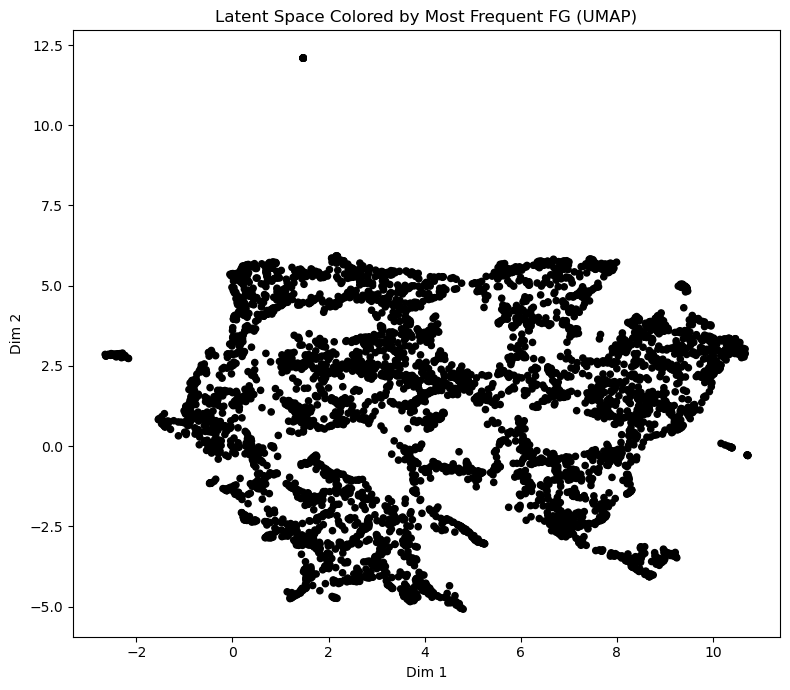

In [2]:
# Plot fingerprint brightness umap
fingerprint_metric_df = pd.read_pickle('data/chembl_35_fg_scaf_curated.pkl')

fingerprint_train, fingerprint_test = train_test_split(fingerprint_metric_df, test_size=0.2, random_state=42)
fingerprint_val, fingerprint_test = train_test_split(fingerprint_test, test_size=0.2, random_state=42)

fingerprint_train_dataset = FingerprintDataset(fingerprint_train, sparse=False)

model = BaseVAETrainer.load_from_checkpoint('checkpoints/fg_bvae_4_8/best-checkpoint.ckpt', map_location='cpu').model

visualize_latent_space_tanimoto(
    model=model,
    dataset=fingerprint_train_dataset,
    method='umap',
    sample_size=5000
)